In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d

Calculando $b$ e $\mu*M$ com parâmetros anteriores:

In [2]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)

    print(f'b = {b_curr}')
    print(' ')
    print(f'mu = {mu_curr}')
    print(f'muM = {mu_curr * M}')
    
    #b = B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    #mu = -log(1 / (np.exp(-0.03 * T_curr ** 2 + 1.31 * T_curr - 4.4)))
    #M = 300000

    print(' ')
    t=0
    print(f'tau_L = {tau_L(T_curr)}')
    print(f'p_ER = {p_ER(R_curr)}')
    print(f'p_LRT = {p_LRT(R_curr,T_curr)}')
    print(f'p_PR = {p_PR(R_curr)}')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T1=27.4
T2=0.025
omega1=0.02
phi1=1.53

R1=146.9
R2=0.033
omega2=0.02
phi2=1.99

B_E=200 #FIXO, NÚMERO MÁXIMO DE OVOS POR OVIPOSIÇÃO
p_ME=0.9
p_ML=0.85
p_MP=0.85
tau_E=1
tau_P=1
c1= 0.019 #0.02
c2=-0.022 #0.15

D1=36.5
b1=0.1
b2=0.3

A= -0.03 #-0.03
B= 1.31 #1.31
C= -2 # -4.4

#tau_H=10 Período latente da infecção em humanos (não é mais usado)
DD=105
Tmin=14.5
gamma= 1/1095 #1/365
R_L = 200
N=8558

M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

b = 10.026960568739408
 
mu = 0.08801387154981206
muM = 26404.16146494362
 
tau_L = 2.003482786673249
p_ER = 0.7183422345843472
p_LRT = 0.41184904005174133
p_PR = 0.6784343326629946
b = 10.026960147949346
 
mu = 0.08801387204935826
muM = 26404.16161480748
 
tau_L = 2.0034827720219033
p_ER = 0.7183422245334461
p_LRT = 0.4118490327859362
p_PR = 0.6784343231704767
b = 10.026958355376703
 
mu = 0.08801387417743255
muM = 26404.162253229762
 
tau_L = 2.0034827096069496
p_ER = 0.7183421817164368
p_LRT = 0.411849001833487
p_PR = 0.6784342827321903
b = 10.026957248694805
 
mu = 0.08801387549124297
muM = 26404.16264737289
 
tau_L = 2.0034826710738036
p_ER = 0.7183421552824659
p_LRT = 0.4118489827243514
p_PR = 0.6784342577667732
b = 10.02695558867127
 
mu = 0.08801387746195867
muM = 26404.1632385876
 
tau_L = 2.00348261327409
p_ER = 0.7183421156314894
p_LRT = 0.4118489540606375
p_PR = 0.6784342203186288
b = 10.026948717181503
 
mu = 0.08801388561951821
muM = 26404.165685855463
 
tau_L = 2.0034823

 
mu = 0.08849994862546268
muM = 26549.984587638803
 
tau_L = 1.9896292850011281
p_ER = 0.6724302897019617
p_LRT = 0.38418870111381137
p_PR = 0.635073051385186
b = 8.457923596466136
 
mu = 0.08816746864480045
muM = 26450.240593440136
 
tau_L = 1.9990191562132076
p_ER = 0.678728470713591
p_LRT = 0.3887037193956256
p_PR = 0.6410213334517247
b = 8.420862687408627
 
mu = 0.08821726067984262
muM = 26465.178203952786
 
tau_L = 1.9975896001722335
p_ER = 0.6777357718042819
p_LRT = 0.38799628077716874
p_PR = 0.6400837844818217
b = 8.613588230530333
 
mu = 0.08796845339760792
muM = 26390.536019282375
 
tau_L = 2.0048185358561708
p_ER = 0.6828675641025814
p_LRT = 0.3916404746208353
p_PR = 0.6449304772079935
b = 8.727367655444516
 
mu = 0.08783211162674662
muM = 26349.633488023985
 
tau_L = 2.008873041834159
p_ER = 0.6858623365874046
p_LRT = 0.39375424884044086
p_PR = 0.6477588734436598
b = 8.727367655444516
 
mu = 0.08783211162674662
muM = 26349.633488023985
 
tau_L = 2.008873041834159
p_ER = 0.6

Modificando $R_1$ e $R_L$, usando dados do site https://pt.climate-data.org/america-do-sul/brasil/amazonas/manaus-1882/#google_vignette, que coloca a pluviosidade média anual como 3001 mm:

In [4]:
R1= 250.083 #146.9
R2= 0.033
omega2= 0.02
phi2=1.99

R_L = 350

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

b = 11.358154614860883
 
mu = 0.08801387154981206
muM = 26404.16146494362
 
tau_L = 2.003482786673249
p_ER = 0.7488202110545578
p_LRT = 0.4293230583506082
p_PR = 0.7072190882181935
b = 11.358154209086376
 
mu = 0.08801387204935826
muM = 26404.16161480748
 
tau_L = 2.0034827720219033
p_ER = 0.748820202134879
p_LRT = 0.42932305166958773
p_PR = 0.7072190797940524
b = 11.358152480480202
 
mu = 0.08801387417743255
muM = 26404.162253229762
 
tau_L = 2.0034827096069496
p_ER = 0.7488201641368963
p_LRT = 0.42932302320833066
p_PR = 0.7072190439070688
b = 11.358151413289308
 
mu = 0.08801387549124297
muM = 26404.16264737289
 
tau_L = 2.0034826710738036
p_ER = 0.7488201406780515
p_LRT = 0.4293230056371843
p_PR = 0.707219021751493
b = 11.358149812502276
 
mu = 0.08801387746195867
muM = 26404.1632385876
 
tau_L = 2.00348261327409
p_ER = 0.7488201054897662
p_LRT = 0.42932297928045543
p_PR = 0.7072189885181125
b = 11.35814318621526
 
mu = 0.08801388561951821
muM = 26404.165685855463
 
tau_L = 2.003482

mu = 0.08934650939818148
muM = 26803.952819454444
 
tau_L = 1.967244111365858
p_ER = 0.6973352936339329
p_LRT = 0.396145912763713
p_PR = 0.6585944439876033
b = 9.273084453321657
 
mu = 0.08908551954266175
muM = 26725.655862798525
 
tau_L = 1.9739272489850077
p_ER = 0.6998832201224107
p_LRT = 0.3982782155876874
p_PR = 0.6610008190044989
b = 9.25487794221626
 
mu = 0.08912686493892037
muM = 26738.05948167611
 
tau_L = 1.972856129593271
p_ER = 0.6994261532546646
p_LRT = 0.3979086556254879
p_PR = 0.6605691447405166
b = 9.356639817092567
 
mu = 0.0889124947450964
muM = 26673.74842352892
 
tau_L = 1.978461898267128
p_ER = 0.7019742014903534
p_LRT = 0.39993222553144603
p_PR = 0.6629756347408894
b = 9.424098924852037
 
mu = 0.08878677054032764
muM = 26636.031162098294
 
tau_L = 1.9818109951367822
p_ER = 0.7036542048349704
p_LRT = 0.40123193417780295
p_PR = 0.6645623045663609
b = 9.424098924852037
 
mu = 0.08878677054032764
muM = 26636.031162098294
 
tau_L = 1.9818109951367822
p_ER = 0.70365420

Printando parâmetros de $T(0)$, $T_{curr}$ e $a$

In [5]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva 
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva 
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)

    #print(f'muM = {mu_curr * M}')

    t=0
    print(Temp(t))
    print(T_curr)
    print(a(Temp(t)))
    print(a(T_curr))
    print(' ')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [6]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

27.427937732700485
27.427937732700485
0.000765417334259907
0.000765417334259907
 
27.427937732700485
27.427937924811694
0.0007654225975806938
0.0007654225975806938
 
27.427937732700485
27.427938743208337
0.0007654450194065266
0.0007654450194065266
 
27.427937732700485
27.42793924846224
0.0007654588619792525
0.0007654588619792525
 
27.427937732700485
27.42794000634306
0.0007654796258373193
0.0007654796258373193
 
27.427937732700485
27.42794314350525
0.0007655655754863246
0.0007655655754863246
 
27.427937732700485
27.42794413640624
0.0007655927782531703
0.0007655927782531703
 
27.427937732700485
27.427942535480028
0.0007655489172610839
0.0007655489172610839
 
27.427937732700485
27.427943643813578
0.0007655792825638067
0.0007655792825638067
 
27.427937732700485
27.427950244554054
0.0007657601247686524
0.0007657601247686524
 
27.427937732700485
27.427949259369075
0.0007657331333993667
0.0007657331333993667
 
27.427937732700485
27.42795419936747
0.0007658684758211296
0.0007658684758211296
 

-0.003758317685508896
 
27.427937732700485
27.241552067823232
-0.0043410392377196344
-0.0043410392377196344
 
27.427937732700485
27.118923590643227
-0.00770072354402113
-0.00770072354402113
 
27.427937732700485
27.136691519360433
-0.00721393097642646
-0.00721393097642646
 
27.427937732700485
27.049999051408548
-0.00958906708469727
-0.00958906708469727
 
27.427937732700485
27.004763924397267
-0.010828385632951555
-0.010828385632951555
 
27.427937732700485
27.004763924397267
-0.010828385632951555
-0.010828385632951555
 
27.427937732700485
27.318716792511566
-0.002226937191463908
-0.002226937191463908
 
27.427937732700485
27.281367812403754
-0.0032501969204450456
-0.0032501969204450456
 
27.427937732700485
27.07608548238448
-0.0088743703456306
-0.0088743703456306
 
27.427937732700485
26.98815318730819
-0.011283474320323549
-0.011283474320323549
 
27.427937732700485
26.97998599987362
-0.011507232880174767
-0.011507232880174767
 
27.427937732700485
26.967913124841843
-0.011837996579675499
-

Printando parâmetros de $T(0)$, $T_{curr}$ e $\mu$

In [7]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva 
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    

    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)

    #print(f'muM = {mu_curr * M}')
    
    print(t)
    print(Temp(t))
    print(mu(Temp(t)))
    print(' ')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]

In [8]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

0.0
27.427937732700485
0.08801387154981206
 
1.40343933816894e-05
27.427937924811694
0.08801387204935826
 
7.382112245259866e-05
27.427938743208337
0.08801387417743255
 
0.00011073168367889801
27.42793924846224
0.08801387549124297
 
0.000166097525518347
27.42794000634306
0.08801387746195867
 
0.00039527820974922905
27.42794314350525
0.08801388561951821
 
0.00046781311272298
27.42794413640624
0.08801388820135889
 
0.00035085983454223504
27.427942535480028
0.0880138840384704
 
0.0004318274886673662
27.427943643813578
0.08801388692047005
 
0.0009140348510125918
27.427950244554054
0.08801390408439043
 
0.000842063602901364
27.427949259369075
0.08801390152261002
 
0.0012029480041448057
27.42795419936747
0.08801391436811362
 
0.0014034393381689401
27.427956943810397
0.08801392150450953
 
0.0014034393381689401
27.427956943810397
0.08801392150450953
 
0.00014034393381689403
27.42793965381247
0.08801387654527414
 
0.00028068786763378806
27.42794157492423
0.08801388154073794
 
0.0010915639296869

204.3718956424677
26.828587700343718
0.08656317605069568
 
202.90887692521042
26.83988451900723
0.08658858283108234
 
210.2448707788862
26.788253832701372
0.08647305301506758
 
214.32042291981716
26.765190470076945
0.0864219315360925
 
214.32042291981716
26.765190470076945
0.0864219315360925
 
188.64444443195202
26.973501997231896
0.08689461260294609
 
191.4973309306037
26.943628193717334
0.08682530283614326
 
207.98067514503566
26.80283301348061
0.08650552315411184
 
216.75203999907703
26.753429204846356
0.0863959768895716
 
217.96784853870696
26.748120314378493
0.08638428667501467
 
219.79156134815187
26.740880563422802
0.08636837012038523
 
227.34061570410685
26.72032585485737
0.08632334036654357
 
229.72986559700416
26.71702943391734
0.08631614075036637
 
225.8775049277074
26.723111161483782
0.08632942839654457
 
228.54452385260515
26.718470333774974
0.08631928703205054
 
244.42810322755176
26.731060283213683
0.08634682713014925
 
242.05741973875377
26.724823016178362
0.08633317225

É possível verificar que, diferente dos valores obtidos pelo t_eval, o valor de t não está atuaizando corretamente na função, até mesmo voltando para um valor "passado". É necessário verificar se isso está afetando incorretamente o código

In [9]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 365)  # Avalia a solução em 365 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

0.0
27.427937732700485
0.08801387154981206
 
1.40343933816894e-05
27.427937924811694
0.08801387204935826
 
7.382112245259866e-05
27.427938743208337
0.08801387417743255
 
0.00011073168367889801
27.42793924846224
0.08801387549124297
 
0.000166097525518347
27.42794000634306
0.08801387746195867
 
0.00039527820974922905
27.42794314350525
0.08801388561951821
 
0.00046781311272298
27.42794413640624
0.08801388820135889
 
0.00035085983454223504
27.427942535480028
0.0880138840384704
 
0.0004318274886673662
27.427943643813578
0.08801388692047005
 
0.0009140348510125918
27.427950244554054
0.08801390408439043
 
0.000842063602901364
27.427949259369075
0.08801390152261002
 
0.0012029480041448057
27.42795419936747
0.08801391436811362
 
0.0014034393381689401
27.427956943810397
0.08801392150450953
 
0.0014034393381689401
27.427956943810397
0.08801392150450953
 
0.00014034393381689403
27.42793965381247
0.08801387654527414
 
0.00028068786763378806
27.42794157492423
0.08801388154073794
 
0.0010915639296869

187.2921805668023
26.98815318730819
0.08692879295445302
 
188.04249188355328
26.97998599987362
0.0869097240779483
 
189.16795885867973
26.967913124841843
0.08688160679483248
 
193.82670300252767
26.920333588124993
0.08677161380263539
 
195.3011795954726
26.906123121095092
0.08673901463599033
 
192.92377417992955
26.92924240804087
0.08679210990268568
 
194.569670236844
26.913120223545473
0.0867550517059192
 
204.3718956424677
26.828587700343718
0.08656317605069568
 
202.90887692521042
26.83988451900723
0.08658858283108234
 
210.2448707788862
26.788253832701372
0.08647305301506758
 
214.32042291981716
26.765190470076945
0.0864219315360925
 
214.32042291981716
26.765190470076945
0.0864219315360925
 
188.64444443195202
26.973501997231896
0.08689461260294609
 
191.4973309306037
26.943628193717334
0.08682530283614326
 
207.98067514503566
26.80283301348061
0.08650552315411184
 
216.75203999907703
26.753429204846356
0.0863959768895716
 
217.96784853870696
26.748120314378493
0.08638428667501467

In [10]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

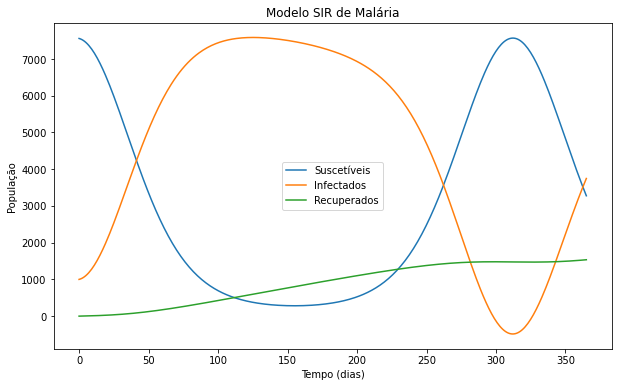

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

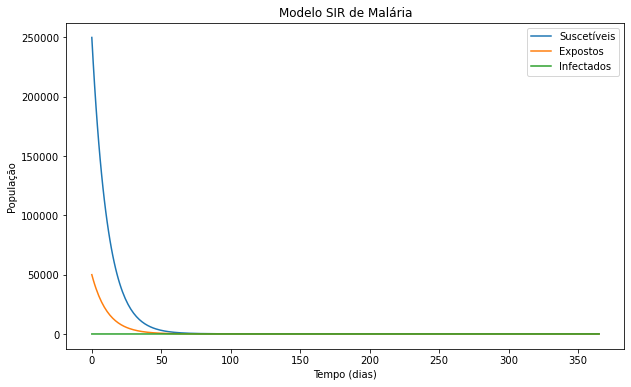

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Calculando a chuva e probabilidade máxima de sobrevivência das larvas

In [13]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva 
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)

    #print(f'muM = {mu_curr * M}')

    t=0
    print(f'Rain_0 = {Rain(t)}')
    print(f'R_curr = {R_curr}')
    print(f'P_L = {p_LR(Rain(t))}')
    print(f'P_L_curr = {p_LR(R_curr)}')
    print(' ')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [14]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 365)  # Avalia a solução em 365 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

Rain_0 = 246.72386118110802
R_curr = 246.72386118110802
P_L = 0.7072190882181935
P_L_curr = 0.7072190882181935
 
Rain_0 = 246.72386118110802
R_curr = 246.72386329697878
P_L = 0.7072190882181935
P_L_curr = 0.7072190797940524
 
Rain_0 = 246.72386118110802
R_curr = 246.7238723106234
P_L = 0.7072190882181935
P_L_curr = 0.7072190439070688
 
Rain_0 = 246.72386118110802
R_curr = 246.7238778753838
P_L = 0.7072190882181935
P_L_curr = 0.707219021751493
 
Rain_0 = 246.72386118110802
R_curr = 246.72388622252788
P_L = 0.7072190882181935
P_L_curr = 0.7072189885181125
 
Rain_0 = 246.72386118110802
R_curr = 246.72392077463715
P_L = 0.7072190882181935
P_L_curr = 0.7072188509520502
 
Rain_0 = 246.72386118110802
R_curr = 246.7239317102763
P_L = 0.7072190882181935
P_L_curr = 0.7072188074127894
 
Rain_0 = 246.72386118110802
R_curr = 246.72391407795666
P_L = 0.7072190882181935
P_L_curr = 0.7072188776142762
 
Rain_0 = 246.72386118110802
R_curr = 246.7239262849452
P_L = 0.7072190882181935
P_L_curr = 0.7072188

Rain_0 = 246.72386118110802
R_curr = 244.31288203721383
P_L = 0.7072190882181935
P_L_curr = 0.7166568400372568
 
Rain_0 = 246.72386118110802
R_curr = 244.17112946233024
P_L = 0.7072190882181935
P_L_curr = 0.7172016856022765
 
Rain_0 = 246.72386118110802
R_curr = 243.96508005690404
P_L = 0.7072190882181935
P_L_curr = 0.7179916758476113
 
Rain_0 = 246.72386118110802
R_curr = 243.20159089259568
P_L = 0.7072190882181935
P_L_curr = 0.7208983363187317
 
Rain_0 = 246.72386118110802
R_curr = 242.99183722986422
P_L = 0.7072190882181935
P_L_curr = 0.7216912182723756
 
Rain_0 = 246.72386118110802
R_curr = 243.33782614805614
P_L = 0.7072190882181935
P_L_curr = 0.720382050277693
 
Rain_0 = 246.72386118110802
R_curr = 243.09390458600376
P_L = 0.7072190882181935
P_L_curr = 0.7213057023509349
 
Rain_0 = 246.72386118110802
R_curr = 242.07278311555197
P_L = 0.7072190882181935
P_L_curr = 0.7251365061343349
 
Rain_0 = 246.72386118110802
R_curr = 242.1759125789346
P_L = 0.7072190882181935
P_L_curr = 0.7247

In [15]:
def lotkavolterra(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M, M_M= z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva 
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva 
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    print(f'b = {b_curr}')
    print(' ')
    print(f'mu = {mu_curr}')
    print(f'muM = {mu_curr * M}')
    print(' ')
    #print(f'dSmdt  = {b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M}')
    #print(f'dEmdt*   = {a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M}')
    #print(f'dEmdt** = {a_curr * b1 * (I_H0 / N) * S_M * l_curr}')
    #print(f'dImdt* = {mu_curr * I_M}')
    #print(' ')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    dMdt = b_curr - mu_curr*M_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt, dMdt] 

In [16]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 365)  # Avalia a solução em 365 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0, M], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

b = 11.358154614860883
 
mu = 0.08801387154981206
muM = 26404.16146494362
 
b = 11.358154161191159
 
mu = 0.08801387210832173
muM = 26404.16163249652
 
b = 11.358152228550503
 
mu = 0.08801387448758129
muM = 26404.162346274385
 
b = 11.358151035394632
 
mu = 0.08801387595646608
muM = 26404.162786939825
 
b = 11.358149245659941
 
mu = 0.08801387815979346
muM = 26404.163447938037
 
b = 11.358141837243123
 
mu = 0.08801388728022351
muM = 26404.166184067053
 
b = 11.358139492500815
 
mu = 0.08801389016680967
muM = 26404.167050042903
 
b = 11.3581432730978
 
mu = 0.08801388551255808
muM = 26404.165653767424
 
b = 11.358140655761918
 
mu = 0.08801388873473208
muM = 26404.166620419623
 
b = 11.358125068026538
 
mu = 0.08801390792458334
muM = 26404.172377375
 
b = 11.358127394559224
 
mu = 0.08801390506042484
muM = 26404.171518127452
 
b = 11.358115728641904
 
mu = 0.08801391942213944
muM = 26404.175826641833
 
b = 11.358109247557618
 
mu = 0.088013927400876
muM = 26404.178220262802
 
b = 11.3

 
b = 9.64072435182895
 
mu = 0.08843306835316596
muM = 26529.920505949787
 
b = 9.587960982922137
 
mu = 0.08851380641750052
muM = 26554.141925250155
 
b = 9.624247540589042
 
mu = 0.08845796964281052
muM = 26537.390892843156
 
b = 9.861449390187637
 
mu = 0.08812228911901467
muM = 26436.6867357044
 
b = 9.823932338749053
 
mu = 0.08817245589360788
muM = 26451.736768082363
 
b = 10.018453982903267
 
mu = 0.08792215217370507
muM = 26376.64565211152
 
b = 10.132654514653598
 
mu = 0.08778540106119286
muM = 26335.62031835786
 
b = 10.132654514653598
 
mu = 0.08778540106119286
muM = 26335.62031835786
 
b = 9.498934592381927
 
mu = 0.08865734714029991
muM = 26597.204142089973
 
b = 9.557415666387094
 
mu = 0.08856194519212031
muM = 26568.58355763609
 
b = 9.95677875955548
 
mu = 0.0879989864328949
muM = 26399.69592986847
 
b = 10.176494712242695
 
mu = 0.08773467762532582
muM = 26320.403287597746
 
b = 10.198587323133744
 
mu = 0.08770947005797584
muM = 26312.841017392755
 
b = 10.23192818

In [17]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M, M_M = sol.y

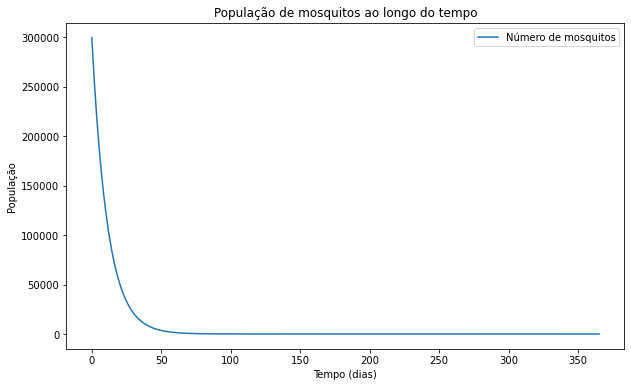

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(times, M_M, label='Número de mosquitos')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('População de mosquitos ao longo do tempo')

plt.legend()

plt.show()

In [19]:
M

300000

In [20]:
N

8558

In [21]:
n(M/N)

35.0549193736854

Diminuindo o número de mosquitos 

In [22]:
M = 30000
E_M0 = None
I_H0 = 1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 365)  # Avalia a solução em 365 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0, M], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

b = 11.358154614860883
 
mu = 0.08801387154981206
muM = 2640.416146494362
 
b = 11.35815391399337
 
mu = 0.08801387241264517
muM = 2640.4161723793554
 
b = 11.358150928285294
 
mu = 0.0880138760883275
muM = 2640.416282649825
 
b = 11.358149084995842
 
mu = 0.08801387835758559
muM = 2640.4163507275675
 
b = 11.358146320059596
 
mu = 0.08801388176147364
muM = 2640.4164528442093
 
b = 11.35813487489009
 
mu = 0.088013895851494
muM = 2640.41687554482
 
b = 11.35813125252421
 
mu = 0.08801390031094004
muM = 2640.4170093282014
 
b = 11.35813709312501
 
mu = 0.08801389312065275
muM = 2640.416793619582
 
b = 11.358133049633327
 
mu = 0.08801389809854362
muM = 2640.416942956309
 
b = 11.358108968283856
 
mu = 0.0880139277446842
muM = 2640.417832340526
 
b = 11.358112562527095
 
mu = 0.08801392331988336
muM = 2640.417699596501
 
b = 11.35809453992232
 
mu = 0.08801394550711282
muM = 2640.4183652133847
 
b = 11.358084527318486
 
mu = 0.08801395783336614
muM = 2640.4187350009843
 
b = 11.358084527

 
b = 10.948321688326175
 
mu = 0.08849583814161312
muM = 2654.8751442483936
 
b = 10.640360450080706
 
mu = 0.08883079812859145
muM = 2664.9239438577433
 
b = 10.640360450080706
 
mu = 0.08883079812859145
muM = 2664.9239438577433
 
b = 12.167820814594572
 
mu = 0.08684051821023217
muM = 2605.2155463069653
 
b = 12.073972522525514
 
mu = 0.08701340096380746
muM = 2610.4020289142236
 
b = 11.115887213696553
 
mu = 0.08830397656612977
muM = 2649.119296983893
 
b = 10.593983365867167
 
mu = 0.08887923184195846
muM = 2666.376955258754
 
b = 10.57082435703935
 
mu = 0.08890321359594378
muM = 2667.096407878313
 
b = 10.536137033377011
 
mu = 0.08893887474539044
muM = 2668.1662423617136
 
b = 10.393557579067199
 
mu = 0.08908208219174302
muM = 2672.4624657522904
 
b = 10.3488992169323
 
mu = 0.08912576802666093
muM = 2673.773040799828
 
b = 10.421032059265087
 
mu = 0.08905492170614179
muM = 2671.647651184254
 
b = 10.371020985324739
 
mu = 0.08910420040906547
muM = 2673.126012271964
 
b = 10

In [23]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M, M_M = sol.y

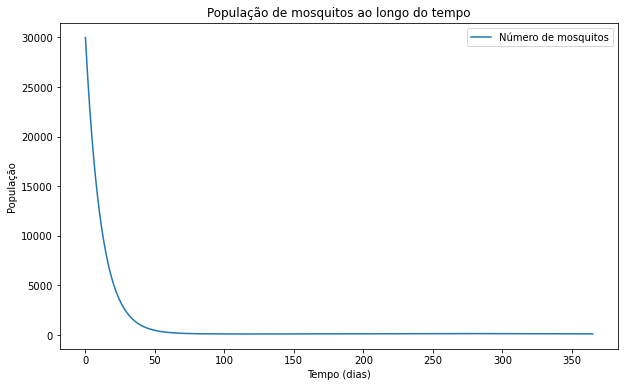

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(times, M_M, label='Número de mosquitos')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('População de mosquitos ao longo do tempo')

plt.legend()

plt.show()

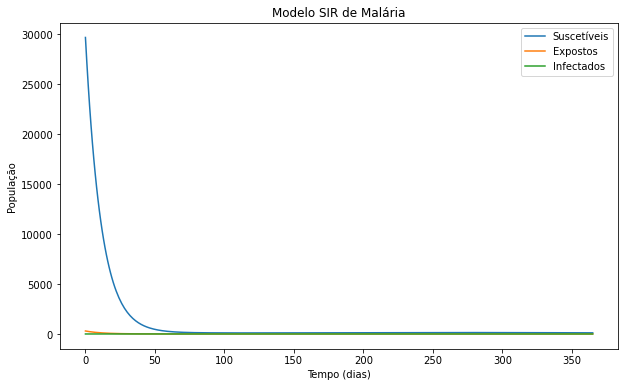

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [26]:
M = 300
E_M0 = 30 #None
I_H0 = 1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 365)  # Avalia a solução em 365 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0, M], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

b = 11.358154614860883
 
mu = 0.08801387154981206
muM = 26.40416146494362
 
b = 11.358153906937451
 
mu = 0.08801387242133166
muM = 26.404161726399497
 
b = 11.358150891171068
 
mu = 0.08801387613401847
muM = 26.40416284020554
 
b = 11.358149029324466
 
mu = 0.08801387842612216
muM = 26.404163527836648
 
b = 11.35814623655245
 
mu = 0.0880138818642785
muM = 26.40416455928355
 
b = 11.358134676159388
 
mu = 0.08801389609614885
muM = 26.404168828844654
 
b = 11.358131017325455
 
mu = 0.08801390060048994
muM = 26.404170180146984
 
b = 11.358136916726286
 
mu = 0.08801389333781512
muM = 26.404168001344537
 
b = 11.358132832526918
 
mu = 0.0880138983658204
muM = 26.40416950974612
 
b = 11.358108508738336
 
mu = 0.0880139283104212
muM = 26.40417849312636
 
b = 11.35811213916676
 
mu = 0.08801392384107398
muM = 26.404177152322195
 
b = 11.358093935118285
 
mu = 0.08801394625167204
muM = 26.404183875501612
 
b = 11.358083821711462
 
mu = 0.08801395870201918
muM = 26.404187610605753
 
b = 11.35

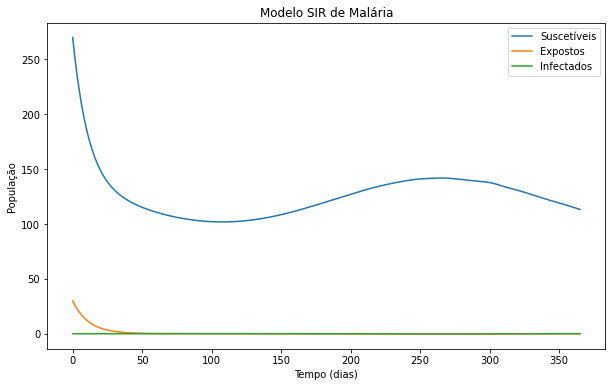

In [27]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M, M_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [28]:
b1=0.5 #0.1
b2=0.3

M= 3000 #100000
E_M0=500 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 365)  # Avalia a solução em 365 pontos entre 0 e 365
sol = solve_ivp(lotkavolterra, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0, M], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

b = 11.358154614860883
 
mu = 0.08801387154981206
muM = 264.0416146494362
 
b = 11.358153908197986
 
mu = 0.08801387241977983
muM = 264.0416172593395
 
b = 11.358150897801496
 
mu = 0.08801387612585583
muM = 264.0416283775675
 
b = 11.358149039270117
 
mu = 0.08801387841387821
muM = 264.04163524163465
 
b = 11.358146251470943
 
mu = 0.08801388184591247
muM = 264.0416455377374
 
b = 11.358134711662485
 
mu = 0.08801389605244143
muM = 264.0416881573243
 
b = 11.358131059343538
 
mu = 0.08801390054876211
muM = 264.04170164628636
 
b = 11.35813694823979
 
mu = 0.08801389329901925
muM = 264.04167989705775
 
b = 11.358132871312819
 
mu = 0.08801389831807156
muM = 264.0416949542147
 
b = 11.358108590835814
 
mu = 0.08801392820935268
muM = 264.04178462805805
 
b = 11.358112214799776
 
mu = 0.08801392374796357
muM = 264.0417712438907
 
b = 11.358094043166089
 
mu = 0.08801394611865705
muM = 264.04183835597115
 
b = 11.358083947767653
 
mu = 0.08801395854683496
muM = 264.0418756405049
 
b = 11.3

mu = 0.08920650490429624
muM = 267.6195147128887
 
b = 9.930522947493689
 
mu = 0.0895026225249028
muM = 268.5078675747084
 


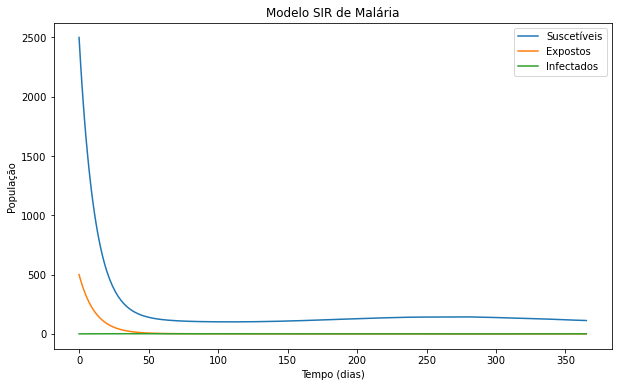

In [29]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M, M_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

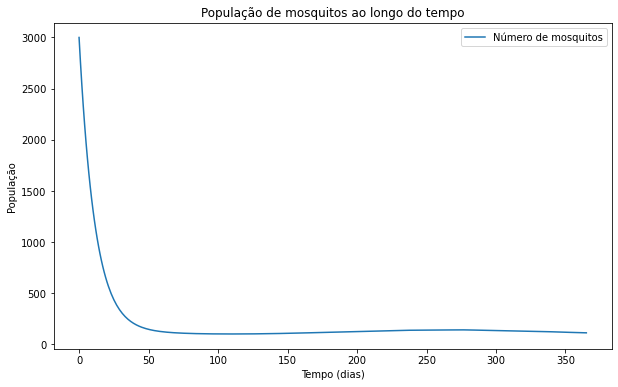

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(times, M_M, label='Número de mosquitos')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('População de mosquitos ao longo do tempo')

plt.legend()

plt.show()